<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Forest" data-toc-modified-id="Time-Forest-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Forest</a></span></li><li><span><a href="#Optimize-Random-Forest-and-lgbm-benchmarks" data-toc-modified-id="Optimize-Random-Forest-and-lgbm-benchmarks-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Optimize Random Forest and lgbm benchmarks</a></span><ul class="toc-item"><li><span><a href="#Tuned-RF" data-toc-modified-id="Tuned-RF-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tuned RF</a></span></li><li><span><a href="#lgbm" data-toc-modified-id="lgbm-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>lgbm</a></span></li></ul></li><li><span><a href="#Out-of-time" data-toc-modified-id="Out-of-time-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Out of time</a></span></li></ul></div>

# GE News - Time Forest Vs Sklearn's Random Forest and LightGBM

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import pdb
import warnings
import seaborn as sns

from sklearn import metrics
from time import time
from sklearn.ensemble import RandomForestClassifier
from models.time_robust_forest import TimeForestClassifier, RandomTimeSplitTree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss, f1_score, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction import stop_words
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings('ignore')

/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
set_style()

In [4]:
STOP_WORDS = ['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'há', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'era', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'estão', 'você', 'tinha', 'foram', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'tu', 'te', 'vocês', 'vos', 'lhes', 'meus', 'minhas', 'teu', 'tua', 'teus', 'tuas', 'nosso', 'nossa', 'nossos', 'nossas', 'dela', 'delas', 'esta', 'estes', 'estas', 'aquele', 'aquela', 'aqueles', 'aquelas', 'isto', 'aquilo', 'estou', 'está', 'estamos', 'estão', 'estive', 'esteve', 'estivemos', 'estiveram', 'estava', 'estávamos', 'estavam', 'estivera', 'estivéramos', 'esteja', 'estejamos', 'estejam', 'estivesse', 'estivéssemos', 'estivessem', 'estiver', 'estivermos', 'estiverem', 'hei', 'há', 'havemos', 'hão', 'houve', 'houvemos', 'houveram', 'houvera', 'houvéramos', 'haja', 'hajamos', 'hajam', 'houvesse', 'houvéssemos', 'houvessem', 'houver', 'houvermos', 'houverem', 'houverei', 'houverá', 'houveremos', 'houverão', 'houveria', 'houveríamos', 'houveriam', 'sou', 'somos', 'são', 'era', 'éramos', 'eram', 'fui', 'foi', 'fomos', 'foram', 'fora', 'fôramos', 'seja', 'sejamos', 'sejam', 'fosse', 'fôssemos', 'fossem', 'for', 'formos', 'forem', 'serei', 'será', 'seremos', 'serão', 'seria', 'seríamos', 'seriam', 'tenho', 'tem', 'temos', 'tém', 'tinha', 'tínhamos', 'tinham', 'tive', 'teve', 'tivemos', 'tiveram', 'tivera', 'tivéramos', 'tenha', 'tenhamos', 'tenham', 'tivesse', 'tivéssemos', 'tivessem', 'tiver', 'tivermos', 'tiverem', 'terei', 'terá', 'teremos', 'terão', 'teria', 'teríamos', 'teriam']
CLUB_WORDS = ["verdão", "tricolor", "fla", "timão", "rubro", 
              "negro", "flamengo", "paulo", "palmeirense", "paulista", 
              "inter", "colorado", "internacional", "colorados", "colorada"]
STOP_WORDS += CLUB_WORDS
MAX_VOCABULARY = 300
positive_case = "flamengo"

In [5]:
data = pd.read_csv("~/Documents/datasets/ge_news/data/ge_news.csv", index_col=False)

In [6]:
data.shape

(139934, 6)

In [7]:
def create_different_time_slices(data, time_col="date", aggregation="weekly", n_months=None):
    if aggregation == "daily": return data[time_col].dt.date
    if aggregation == "weekly": return data[time_col].dt.week
    if aggregation == "monthly": return data[time_col].apply(lambda x: x.strftime("%Y-%m"))
    if aggregation == "semester": return False


def exclude_periods_without_positive_case(data, positive_case, period_column, threshold=20):
    df = data.groupby(period_column)["club"].apply(lambda x: np.sum(x == positive_case))
    df = df[df > threshold]
    return data[data[period_column].isin(df.index)]
    
def clean_club_name_from_article(data):
    data["text"] = data.apply(lambda x: x["text"].lower().replace(x["club"].replace("-", " "), ""), axis=1)
    return data

def exclude_numbers(data):
    data["text"] = data["text"].apply(lambda x: ''.join([i for i in x.lower() if not i.isdigit()]))
    return data

def drop_multiple_teams_news(data):
    multiple_team_news = data.groupby("link", as_index=False)["club"].count()
    multiple_team_news = multiple_team_news[multiple_team_news["club"] > 1]["link"]
    return data[~data["link"].isin(multiple_team_news)]


In [8]:
data = clean_club_name_from_article(data)
data = exclude_numbers(data)
data = drop_multiple_teams_news(data)

In [9]:
data = data.sample(frac=0.2)

In [10]:
data.loc[:, "year"] = data["date"].apply(lambda x: x.split("/")[-1])
data.loc[:, "month"] = data["date"].apply(lambda x: x.split("/")[1])
data.loc[:, "date"] = pd.to_datetime(data["date"])

In [11]:
### Monthly context
data["year-month"] = data["year"] + "-" + data["month"]

### Weekly context
data["year-week"] = create_different_time_slices(data)
data["year-week"] = data["year"] + "-" + data["year-week"].astype(str)

In [12]:
data["target"] = data["club"].apply(lambda x: 1 if x == positive_case else 0)

print("The fraction of positive cases is {:.2f}".format(data["target"].mean()))

The fraction of positive cases is 0.09


In [13]:
data = exclude_periods_without_positive_case(data, positive_case, "year-month")

In [14]:
train_end_date = "2019-01"
holdout_end_date = "2021-07"
train_end_year = int(train_end_date.split("-")[0])

In [15]:
in_time = data[data["year-month"] < train_end_date]

train, test = train_test_split(in_time, 
                               test_size=0.2, 
                               random_state=42)

out_of_time = data[(data["year-month"] >= train_end_date) & (data["year-month"] <= holdout_end_date)]



In [16]:
target = "target"
time_column = "year-month"
time_column = "year"

In [17]:
print("Dataset shapes:")
print("Train: {}".format(train.shape))
print("Test: {}".format(test.shape))
print("Out of time: {}".format(out_of_time.shape))

Dataset shapes:
Train: (5740, 11)
Test: (1436, 11)
Out of time: (11737, 11)


In [18]:
vectorizer = TfidfVectorizer(max_features=MAX_VOCABULARY,
                             stop_words=STOP_WORDS,
                             binary=True,
                             use_idf=False,
                             norm=False)

train_vectors = pd.DataFrame(vectorizer.fit_transform(train["text"]).toarray(), columns=vectorizer.vocabulary_)
test_vectors = pd.DataFrame(vectorizer.transform(test["text"]).toarray(), columns=vectorizer.vocabulary_)
oot_vectors = pd.DataFrame(vectorizer.transform(out_of_time["text"]).toarray(), columns=vectorizer.vocabulary_)

In [19]:
train_vectors[time_column] = train[time_column].values
test_vectors[time_column] = test[time_column].values
oot_vectors[time_column] = out_of_time[time_column].values

In [20]:
model = RandomForestClassifier(max_depth=10, n_estimators=25)

In [21]:
model.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [22]:
train["prediction"] = model.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction"])

0.9833458085429438

In [23]:
test["prediction"] = model.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction"])

0.8333966630130313

In [24]:
out_of_time["prediction"] = model.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction"])

0.7053171448593225

## Optimize Random Forest and lgbm benchmarks

In [25]:
from pycaret.classification import *

In [26]:
train_features = pd.DataFrame(train_vectors)

In [27]:
features = [col for col in train_features.columns if col != time_column]

In [28]:
train_features

,outro,lado,mundo,jogadores,futebol,chance,dois,corinthians,disse,clube,entanto,chegou,tudo,porque,início,temporada,contrato,atacante,quase,além,disso,anos,assim,pouco,antes,ainda,deu,caso,conseguiu,fim,voltar,acordo,qualquer,vai,bom,momento,seleção,melhor,gols,partidas,dentro,campo,rio,janeiro,segunda,desde,meio,ano,passado,jogador,possível,três,cada,ficou,time,após,vitória,disputa,apesar,empate,tempo,treinador,título,fluminense,primeira,ataque,silva,outra,primeiro,fazer,equipe,acho,grande,partida,todo,dia,final,campeonato,seis,torcedores,estádio,santos,semana,clássico,torcida,contra,jogar,noite,sexta,feira,apenas,duas,veja,confira,entrevista,grupo,infelizmente,atletas,abaixo,quarta,nova,competição,importante,jogo,agora,hoje,resultado,ver,vamos,trabalhar,bem,derrota,frente,segundo,todos,libertadores,gente,dar,vencer,casa,difícil,chegar,estreia,trabalho,torcedor,série,sete,jogos,brasileiro,quinta,próxima,classificação,técnico,palmeiras,domingo,boa,sempre,sobre,adversário,feliz,bola,gol,meia,disponível,vídeo,outros,vou,parte,situação,entrou,lá,sabe,fase,vitórias,ganhar,sul,goleiro,fez,treino,área,defesa,bruno,sequência,falta,dá,direito,deve,última,tabela,lateral,cinco,pontos,muita,elenco,nesta,felipe,mg,último,então,base,atleta,vem,onde,copa,durante,brasileirão,últimos,partir,clique,aqui,notícias,arena,neste,vez,local,horário,brasília,provável,escalação,léo,lesão,coxa,faz,henrique,thiago,pr,oliveira,real,globoesporte,sendo,deste,principal,vice,profissional,forma,titular,voltou,volta,sido,diante,esquerdo,sábado,tarde,sair,saída,atlético,leia,brasil,duelo,bastante,claro,maior,novo,volante,paranaense,marcou,feito,grêmio,desta,conta,eduardo,atual,camisa,esporte,terça,presidente,alguns,zagueiro,marcelo,muitas,rodrigo,afirmou,coletiva,deixou,próximo,nada,coisas,estar,vezes,meses,porém,logo,acabou,terceiro,diretoria,clubes,cruzeiro,precisa,entrar,lucas,pode,enquanto,atrás,posição,minutos,botafogo,lugar,vaga,diego,ex,ficar,fica,busca,forte,carlos,gaúcho,decisão,campeão,rodada,perdeu,quatro,vasco,passou,problema,quer,menos,relação,oportunidade,dias,técnica,year
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0

In [29]:
train_data_opt = train_features.copy(deep=True)
train_data_opt[target] = train[target].values

In [30]:
train_data_opt.shape

(5740, 302)

In [31]:
train_data_opt

,outro,lado,mundo,jogadores,futebol,chance,dois,corinthians,disse,clube,entanto,chegou,tudo,porque,início,temporada,contrato,atacante,quase,além,disso,anos,assim,pouco,antes,ainda,deu,caso,conseguiu,fim,voltar,acordo,qualquer,vai,bom,momento,seleção,melhor,gols,partidas,dentro,campo,rio,janeiro,segunda,desde,meio,ano,passado,jogador,possível,três,cada,ficou,time,após,vitória,disputa,apesar,empate,tempo,treinador,título,fluminense,primeira,ataque,silva,outra,primeiro,fazer,equipe,acho,grande,partida,todo,dia,final,campeonato,seis,torcedores,estádio,santos,semana,clássico,torcida,contra,jogar,noite,sexta,feira,apenas,duas,veja,confira,entrevista,grupo,infelizmente,atletas,abaixo,quarta,nova,competição,importante,jogo,agora,hoje,resultado,ver,vamos,trabalhar,bem,derrota,frente,segundo,todos,libertadores,gente,dar,vencer,casa,difícil,chegar,estreia,trabalho,torcedor,série,sete,jogos,brasileiro,quinta,próxima,classificação,técnico,palmeiras,domingo,boa,sempre,sobre,adversário,feliz,bola,gol,meia,disponível,vídeo,outros,vou,parte,situação,entrou,lá,sabe,fase,vitórias,ganhar,sul,goleiro,fez,treino,área,defesa,bruno,sequência,falta,dá,direito,deve,última,tabela,lateral,cinco,pontos,muita,elenco,nesta,felipe,mg,último,então,base,atleta,vem,onde,copa,durante,brasileirão,últimos,partir,clique,aqui,notícias,arena,neste,vez,local,horário,brasília,provável,escalação,léo,lesão,coxa,faz,henrique,thiago,pr,oliveira,real,globoesporte,sendo,deste,principal,vice,profissional,forma,titular,voltou,volta,sido,diante,esquerdo,sábado,tarde,sair,saída,atlético,leia,brasil,duelo,bastante,claro,maior,novo,volante,paranaense,marcou,feito,grêmio,desta,conta,eduardo,atual,camisa,esporte,terça,presidente,alguns,zagueiro,marcelo,muitas,rodrigo,afirmou,coletiva,deixou,próximo,nada,coisas,estar,vezes,meses,porém,logo,acabou,terceiro,diretoria,clubes,cruzeiro,precisa,entrar,lucas,pode,enquanto,atrás,posição,minutos,botafogo,lugar,vaga,diego,ex,ficar,fica,busca,forte,carlos,gaúcho,decisão,campeão,rodada,perdeu,quatro,vasco,passou,problema,quer,menos,relação,oportunidade,dias,técnica,year,target
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,1
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.

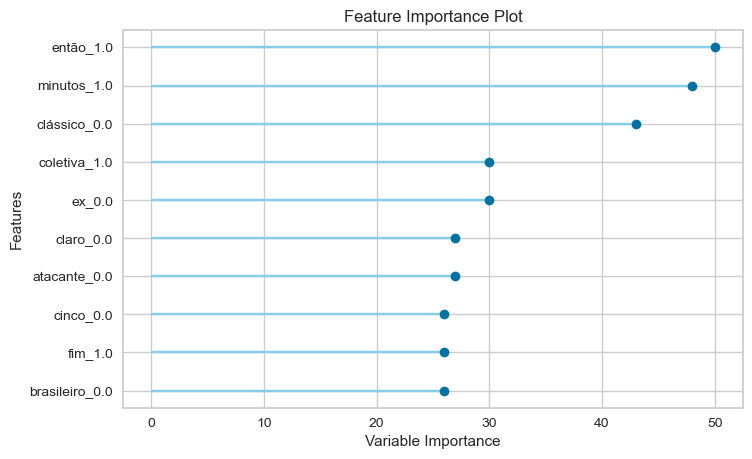

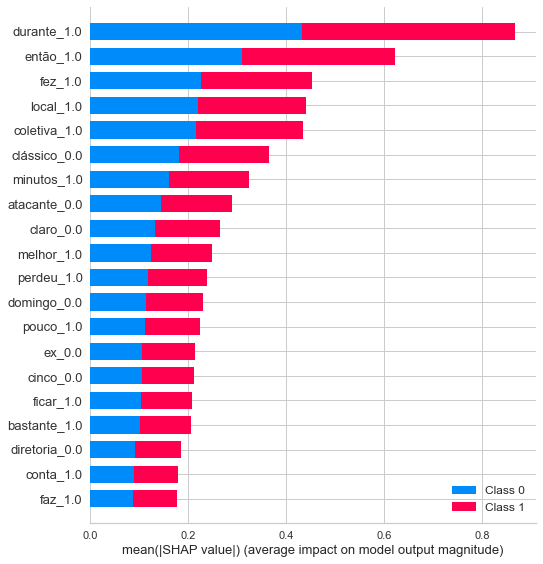

LGBMClassifier(bagging_fraction=0.9, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=240, n_jobs=-1, num_leaves=30, objective=None,
               random_state=57, reg_alpha=0.01, reg_lambda=0.0005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [32]:
clf1 = setup(train_data_opt[features + [target]],
             target="target",
             session_id=57,
             log_experiment=False, 
             experiment_name="ge_binary",
             silent=True)

#best_model = compare_models()

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

lgbm = create_model("lightgbm")

tuned_lgbm = tune_model(lgbm,
                        fold=5,
                        n_iter=50,
                        optimize="AUC")

plot_model(tuned_lgbm, plot="feature")
interpret_model(tuned_lgbm)

best = automl(optimize='AUC')
best

### Tuned RF

In [33]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=190,
                       n_jobs=-1, oob_score=False, random_state=57, verbose=0,
                       warm_start=False)

In [34]:
benchmark = tuned_rf

In [35]:
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=8, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=9,
                       min_weight_fraction_leaf=0.0, n_estimators=190,
                       n_jobs=-1, oob_score=False, random_state=57, verbose=0,
                       warm_start=False)

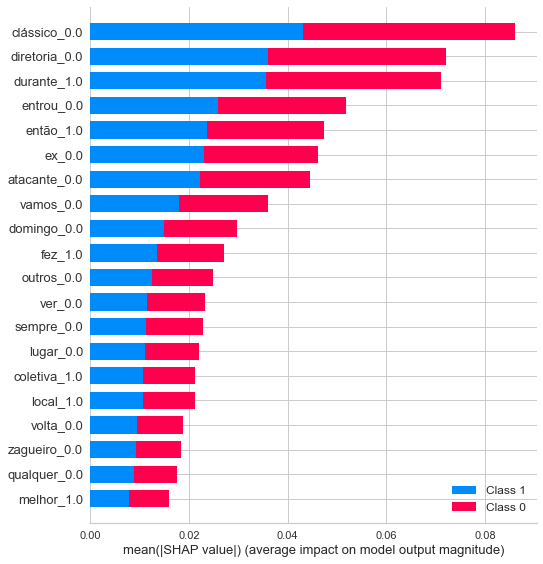

In [36]:
interpret_model(benchmark)

In [37]:
train["prediction_rf"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(train[target], train["prediction_rf"])

0.9361960596545462

In [38]:
test["prediction_rf"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(test[target], test["prediction_rf"])

0.887653148215808

In [39]:
out_of_time["prediction_rf"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
roc_auc_score(out_of_time[target], out_of_time["prediction_rf"])

0.7933890503669784

### lgbm

In [40]:
tuned_lgbm

LGBMClassifier(bagging_fraction=0.9, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=46, min_child_weight=0.001, min_split_gain=0.6,
               n_estimators=240, n_jobs=-1, num_leaves=30, objective=None,
               random_state=57, reg_alpha=0.01, reg_lambda=0.0005, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [41]:
benchmark = tuned_lgbm
benchmark.fit(train_vectors.drop(columns=["year"]), train["target"].values)
train["prediction_lgbm"] = benchmark.predict_proba(train_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(train[target], train["prediction_lgbm"]))

test["prediction_lgbm"] = benchmark.predict_proba(test_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(test[target], test["prediction_lgbm"]))

out_of_time["prediction_lgbm"] = benchmark.predict_proba(oot_vectors.drop(columns=["year"]))[:, 1]
print(roc_auc_score(out_of_time[target], out_of_time["prediction_lgbm"]))

0.9835563365956647
0.9059943977591036
0.8016094938477556


## Time Forest

In [48]:
time_model = TimeForestClassifier(n_estimators=190, 
                                  time_column=time_column, 
                                  max_depth=8,
                                  min_sample_periods=10,
                                  n_jobs=-1,
                                  multi=True)

time_model.fit(train_vectors, train["target"].values)

#train["time_prediction"] = time_model.predict(train_vectors)
train["time_prediction"] = time_model.predict_proba_(train_vectors)
print(roc_auc_score(train[target], train["time_prediction"]))

test["time_prediction"] = time_model.predict_proba_(test_vectors)
print(roc_auc_score(test[target], test["time_prediction"]))

out_of_time["time_prediction"] = time_model.predict_proba_(oot_vectors)
print(roc_auc_score(out_of_time[target], out_of_time["time_prediction"]))

0.8646409885031768
0.8417440019486054
0.7389962316262522


In [49]:
time_model.feature_importance[:20]

durante      76
minutos      68
diretoria    67
bastante     66
ex           65
nada         53
clássico     53
temporada    52
coletiva     49
conseguiu    48
sempre       47
qualquer     47
vamos        47
fez          46
então        46
porém        46
vencer       45
grêmio       45
campo        44
jogos        43
Name: Feature Importance, dtype: int64

## Out of time

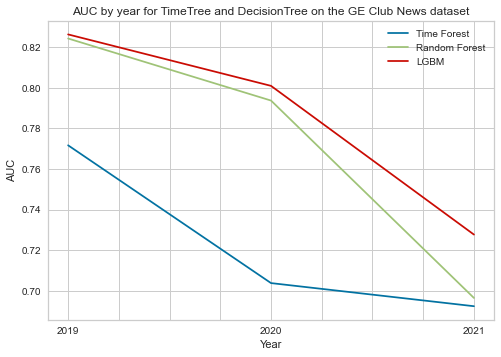

In [50]:
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
out_of_time.groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

plt.legend()
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

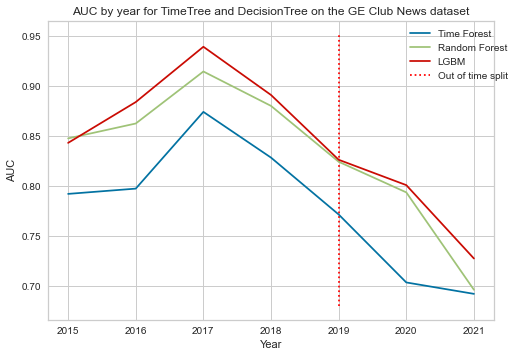

In [51]:
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM")

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Out of time split")
plt.legend(bbox_to_anchor=(1.05, 1.0))

plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")
plt.ylabel("AUC")
plt.xlabel("Year")
plt.show()

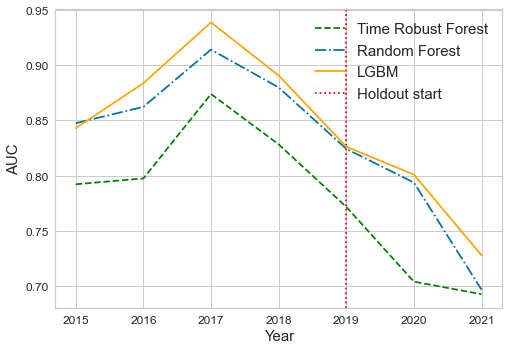

In [52]:
fig, ax = plt.subplots()

pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["time_prediction"])).plot(label="Time Robust Forest",
                                                                                                                        color="green", linestyle="dashed")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_rf"])).plot(label="Random Forest", 
                                                                                                                       linestyle="-.")
pd.concat([test, out_of_time]).groupby(time_column).apply(lambda x: roc_auc_score(x[target], x["prediction_lgbm"])).plot(label="LGBM", color="orange")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.vlines(4, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
#plt.legend(bbox_to_anchor=(1.05, 1.0))
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))

#plt.legend(bbox_to_anchor=(1.05, 1.0))
#plt.title("AUC by year for TimeTree and DecisionTree on the GE Club News dataset")

plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
#plt.savefig("images/ge_sklearn.eps", format="eps", bbox_inches="tight")
plt.savefig("../images/ge_sklearn_binary.eps", format="eps")
plt.show()